#### Final classifier:
I will transform the problem into a binary one (healthy , disease), and use the LogisticRegression model from hierarchical_approach1.ipynb. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle as pk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, matthews_corrcoef, confusion_matrix, ConfusionMatrixDisplay, make_scorer, recall_score
from sklearn.linear_model import LogisticRegression
import time

In [3]:
# set seaborn theme

sns.set_theme(context='notebook', style='whitegrid', palette='bright')

In [4]:
# import training

with open("x_training.pkl" , "rb") as file:
    x_training = pk.load(file)
with open("y_training.pkl" , "rb") as file:
    y_training = pk.load(file)

# import testing

with open("x_benchmark.pkl" , "rb") as file:
    x_testing = pk.load(file)
with open("y_benchmark.pkl" , "rb") as file:
    y_testing = pk.load(file)

In [5]:
# transform outputs in binary (0 --> 0 , 1 or 2 --> 1)
y_training_binary = np.where(y_training <= 1 , y_training , 1)
y_testing_binary = np.where(y_testing <= 1 , y_testing , 1)

# check that disease proportion is the same in the two datasets
print((y_training_binary == 1).mean())
print((y_testing_binary == 1).mean())

0.15758949469067973
0.15758352222331723


In [6]:
# initialize model

logistic_reg = Pipeline([
    ('scaler', StandardScaler()), 
    ('lgr', LogisticRegression(
        solver="lbfgs", 
        max_iter=2000, 
        class_weight="balanced"
    ))
])

In [8]:
# use custom function to predict using desired threshold

def predict_custom(model, x, threshold):

    ''' function to enable the use of a selected threshold
        for classification'''
    
    # predict probabilities instead of just predict
    probs = model.predict_proba(x)[:, 1]
    # apply thresholds
    return (probs >= threshold).astype(int)

In [9]:
# fit on training
start = time.time()

logistic_reg.fit(x_training , y_training_binary)

end= time.time()

print(f"Training took {(end-start):.1f} seconds")
# predict on testing using optimal threshold 0.2
y_pred = predict_custom(logistic_reg , x_testing , 0.2)

Training took 0.3 seconds


#### Overall performance: confusion matrix

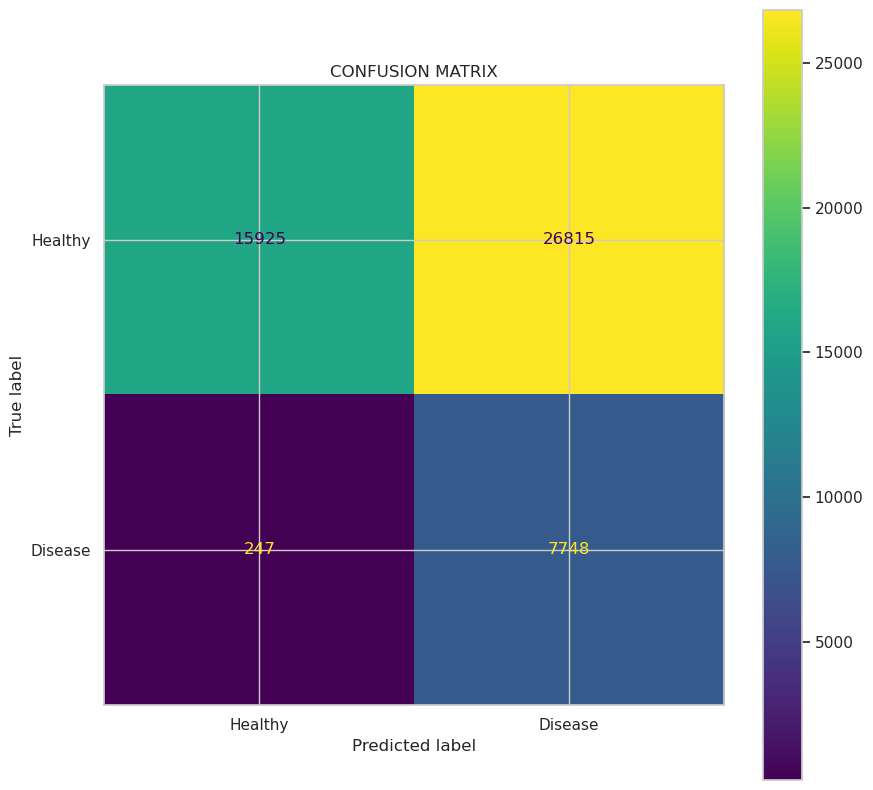

False alarms: 26815
Catches:  7748
Ratio (number of false alarms for each correct prediction): 3.5
---------------------------------------------------------------------------------------------------------------------------
Precision:   0.22
Recall:      0.97
Specificity: 0.37
FPR:         0.63


In [75]:
cm = confusion_matrix(y_testing_binary, y_pred, labels=[0, 1])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Disease'])

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap='viridis', ax=ax, values_format='d') 
plt.title(f"CONFUSION MATRIX")
plt.show()

# Let's see how many healthy people misclassifications we have against correct disease classification
print(f"False alarms: {cm[0,1]}\nCatches:  {cm[1,1]}\nRatio (number of false alarms for each correct prediction): {cm[0,1]/cm[1,1]:.1f}")
print("---------------------------------------------------------------------------------------------------------------------------")
print(f"Precision:   {(cm[1,1] / (cm[1,1] + cm[0,1])):.2f}")
print(f"Recall:      {(cm[1,1] / (cm[1,1] + cm[1,0])):.2f}")
print(f"Specificity: {(cm[0,0] / (cm[0,0] + cm[0,1])):.2f}")
print(f"FPR:         {(cm[0,1] / (cm[0,1] + cm[0,0])):.2f}")

#### Discussion:

For each correct disease prediction, we have 3.5 false positives. In fact, precision is low at 22%.  
Recall on the other hand is very high.  As I said previously, it is also important to look at how many of the 3% disease that we did not spot are diabetics and prediabetics.  
Specificity is low 0.37, meaning that the model only correclty identifies 37% of healthy people.  
As a screening tool, this is not optimal.  
Being able to send home at least 60% of people without directing them to further and more costly investigations, such as blood glucose tests, would have been a good result, but I have to settle for this result.  
It is important to remember that using HistGradientBoosting would probably increse specificity to around 40%, but at the cost of many more false negatives.  
Here I only present LogisticRegression becuase it is cheaper, and has comparable results, but for hostpitals that need to cut costs, HistGradientBoosting is still an option.

## False negatives analysis

#### 1. False Negatives subclass composition

In [11]:
# add a new "prediction" and "class" column to x_testing dataframe:

prediction_df = x_testing.copy()
prediction_df["class_"] = y_testing
prediction_df["prediction"] = y_pred

In [12]:
# create df with only healthy predictions
FN_df = prediction_df.query("(prediction == 0) and (class_ == 1 or class_ == 2)")

FN_plot = FN_df.assign(
    Condition = FN_df["class_"].map({1: 'Pre-diabetes', 2: 'Diabetes'})
)

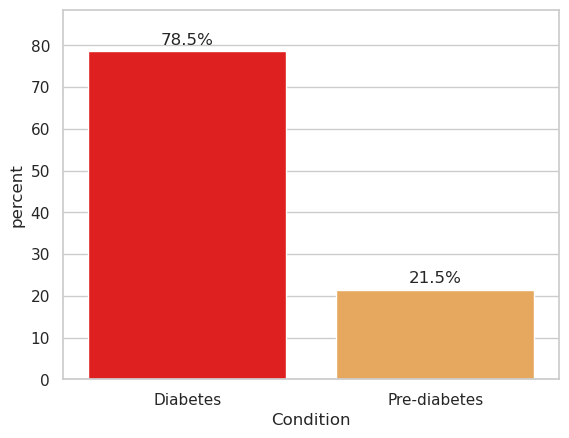

In [76]:
my_colors = {
    "Pre-diabetes": 'xkcd:light orange', 
    "Diabetes": 'red'    
}

hist = sns.countplot(
    data=FN_plot,
    x=FN_plot["Condition"],
    hue=FN_plot["Condition"],
    palette=my_colors,
    stat = "percent"
)

for container in hist.containers:
    hist.bar_label(container, fmt='%.1f%%', padding=3, fontsize=12)

current_max = FN_plot['Condition'].value_counts(normalize=True).max() * 100
plt.ylim(0, current_max + 10) 
plt.show()

In [14]:
print(f"Number of pre-diabetes false negatives:                {FN_df.query("class_ == 1").shape[0]}")
print(f"Total number of pre-diabetics in testing set:          {prediction_df.query(" class_ == 1").shape[0]}")
print(f"Percentage of false negative pre-diabetes predictions: {(FN_df.query('class_ == 1').shape[0] / prediction_df.query('class_ == 1').shape[0])*100:.2f}%\n")
print(f"Number of diabetes false negatives:                    {FN_df.query("class_ == 2").shape[0]}")
print(f"Total number of diabetics in testing set:              {prediction_df.query("class_ == 2").shape[0]}")
print(f"Percentage of false negative diabetes predictions:     {(FN_df.query("class_ == 2").shape[0] / prediction_df.query("class_ == 2").shape[0])*100:.2f}%\n")

Number of pre-diabetes false negatives:                53
Total number of pre-diabetics in testing set:          926
Percentage of false negative pre-diabetes predictions: 5.72%

Number of diabetes false negatives:                    194
Total number of diabetics in testing set:              7069
Percentage of false negative diabetes predictions:     2.74%



#### 1. Discussion:
Among the False Negatives, 78 % belong to the diabetes class, while 21.5% belong to the prediabetes class.  
As I said previously, the goal was to reduce misclassification of prediabetics since diabetic people probably already know they have diabetes.  
To have just 53 prediabetics misclassified on a total of 926 prediabetics (6% of them) is a good achievement.  
Many more diabetics have been miscalssified, but given they are more represented in the dataset, only 3% of them are misclassified.  
Even if the model has been optimized to recall prediabetics, their misclassification rate is higher than that of diabetics, highlighting the difficulty in distinguishing them from healthy individuals

#### 2. False negatives vs True negatives feature distributions

In [15]:
# now look at some relevant features distribution

# create "type" column that holds classification label
FN_df["type"] = "FN"
# create a true negative df
TN_df = prediction_df.query(" class_ == 0 and prediction == 0")
TN_df["type"] = "TN"
# concatenate these two df
TNFN_df = pd.concat([FN_df , TN_df] , axis=0)

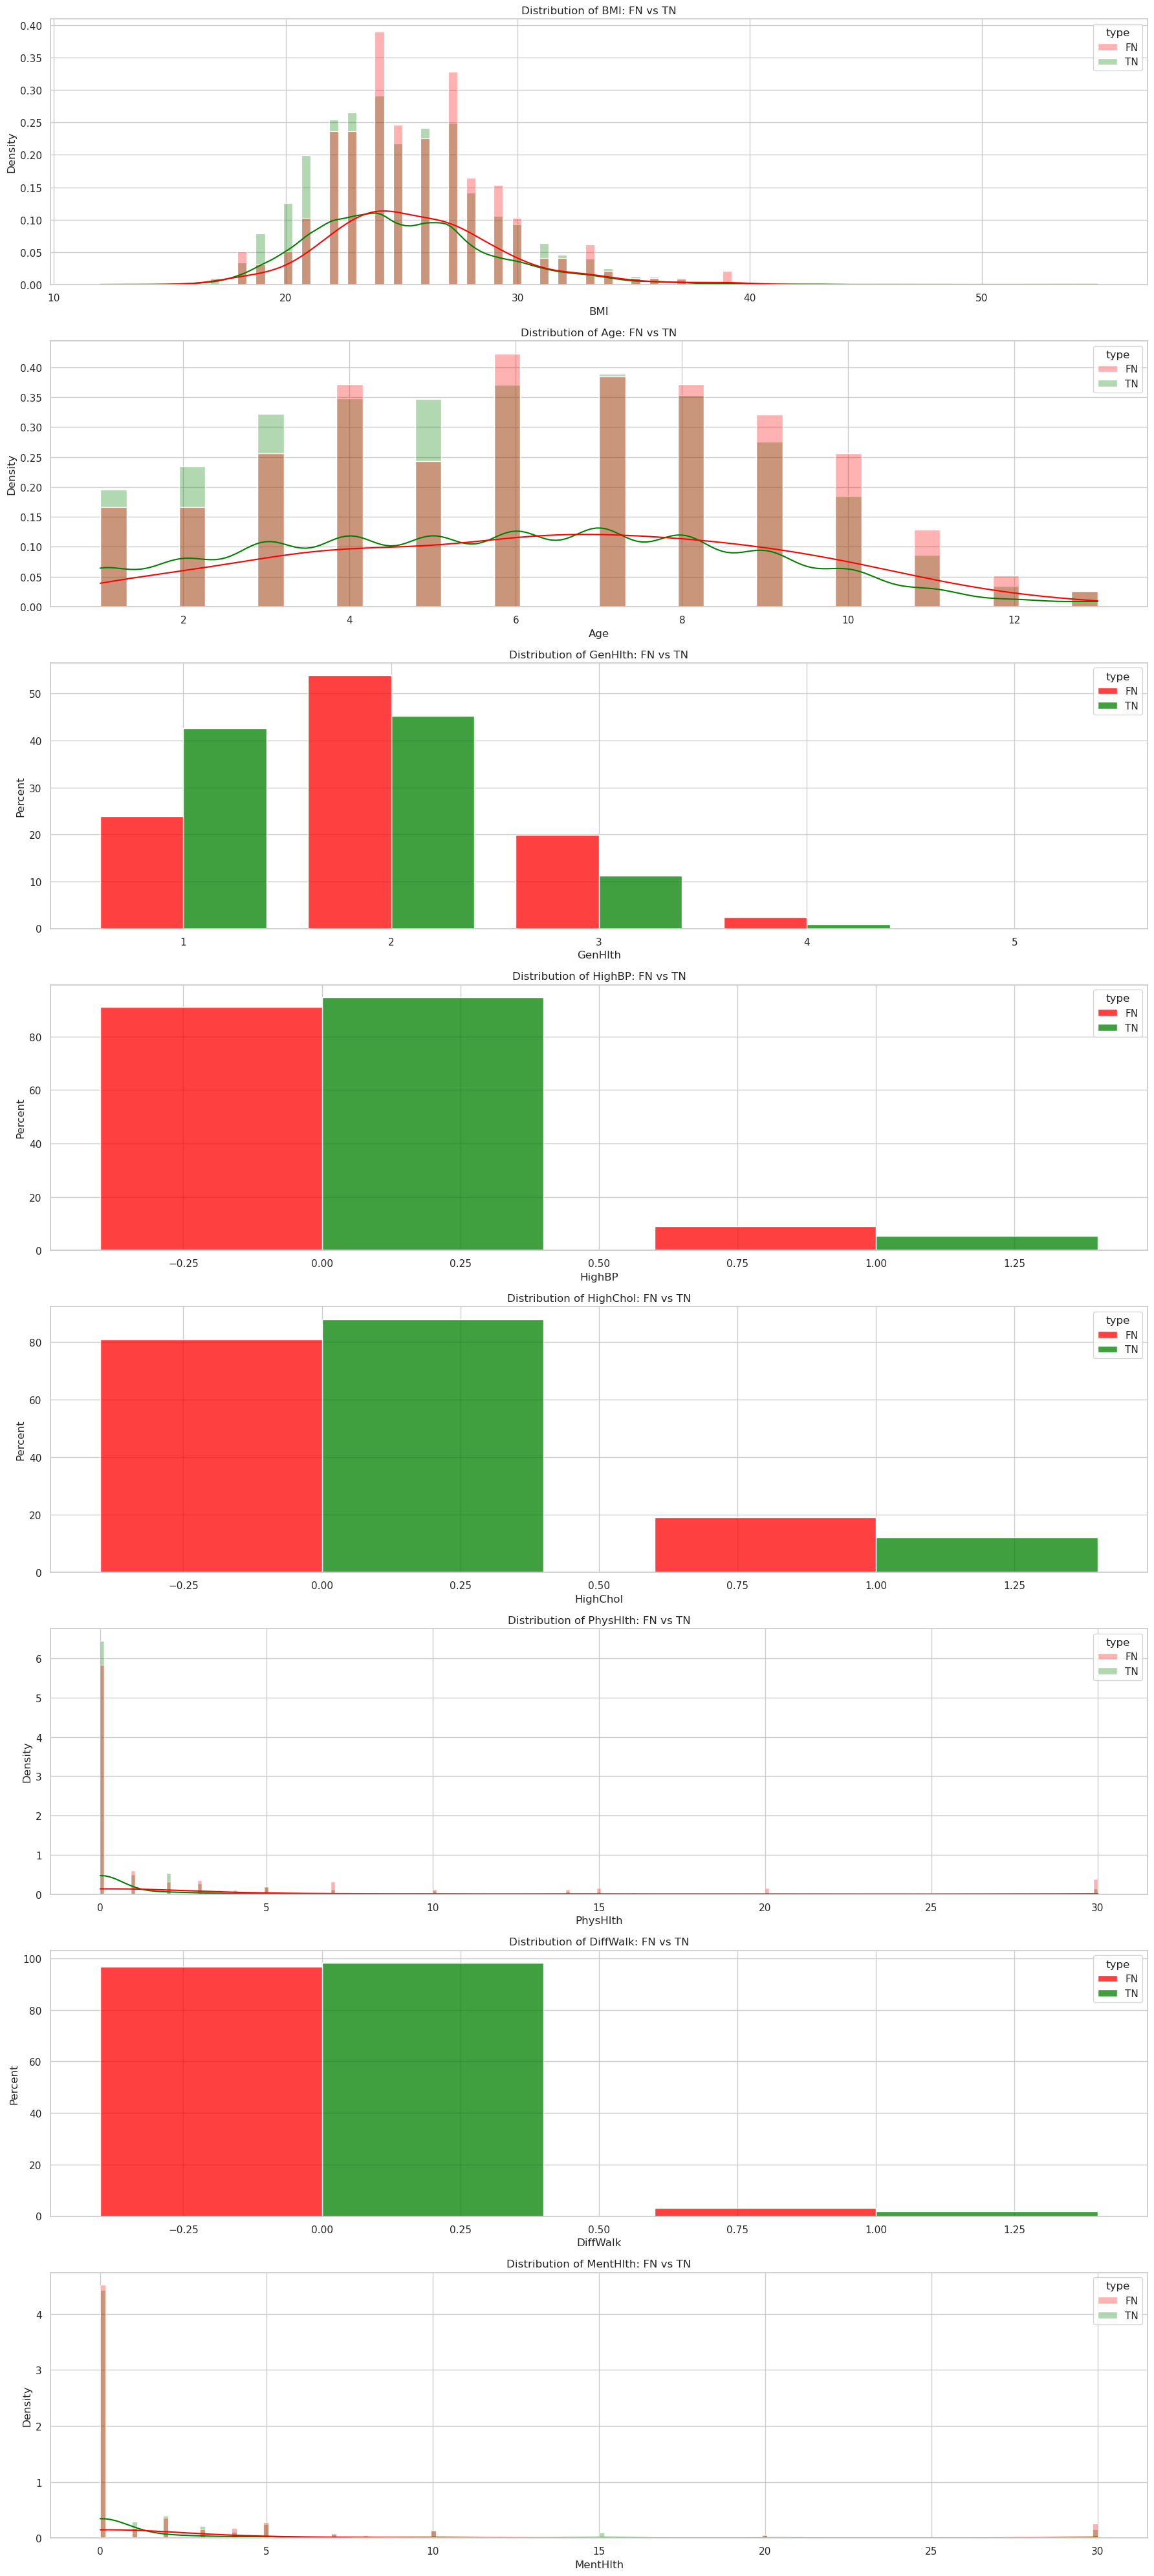

In [16]:
features_to_check = ['BMI' , 'Age', 'GenHlth', 'HighBP', 'HighChol', 'PhysHlth' , 'DiffWalk' , 'MentHlth'] 

palette = {'FN': 'red', 'TN': 'green'}

plt.figure(figsize=(18, 5 * len(features_to_check)))

for i, feature in enumerate(features_to_check):
    plt.subplot(len(features_to_check), 1, i + 1)
    if feature in ["BMI" , "Age" , "MentHlth" , "PhysHlth"]:
        
        
        sns.histplot(
            data=TNFN_df,
            x=feature,
            hue="type",
            stat="density",     
            common_norm=False,  
            kde=True,           
            palette=palette,
            alpha=0.3
        )
    else:
        sns.histplot(
            data=TNFN_df,
            x=feature,
            hue="type",
            stat="percent",      
            common_norm=False,   
            multiple="dodge",    
            discrete=True,      
            shrink=0.8,
            palette=palette
        )
    plt.title(f'Distribution of {feature}: FN vs TN')
plt.tight_layout()
plt.show()

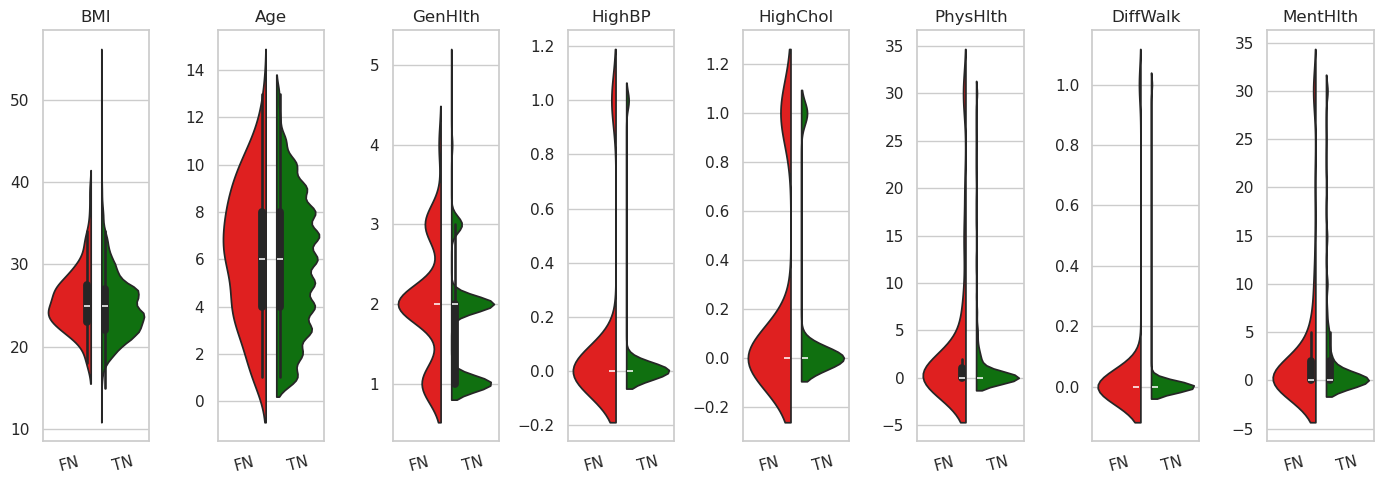

In [74]:
plt.figure(figsize=(14, 5))

for i, feature in enumerate(features_to_check):
    plt.subplot( 1, len(features_to_check), i + 1)
    sns.violinplot(
        data=TNFN_df,
        x='type',
        y=feature,
        palette={'FN': 'red', 'TN': 'green'},
        split = True)
    
    plt.title(feature)
    plt.xticks(rotation=15)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

#### 2. Discussion:
Comparing True Negatives and False Negatives distributions of some of the features, it is clear why they are misclassified.  
All distributions almost overlap.  
BMI: distributions almost overlap. TN distribution is unsurprisingly shifted to the left, but this behaviour vanishes in the right tail of the distribution, suggesting there are a lot of high BMI individuals even among the negatives.  
AGE: distributions overlap, but TN distribution is shifted to the right compared to FN. This is expected and confirmed by science: older people are at more risk of being diabetic or prediabetic(type 2 diabetes at least).  
GEN_HLTH: this is an interesting finding. FN reported as a whole less score 1 general health, but more 2, 3, or 4's, Meaning they felt less in shape than TN, highlighting the importance of self health perception. But again, the two distributions are very similar.  
OTHER FEATURES: distributions are virtually the same so there is nothing to say.  

Looking at this data, it is clear why these misclassifications occurred: distributions overlap. 

#### 3. Probability analysis:
Was the model blind towards false negatives or were the false negatives almost correctly classified?

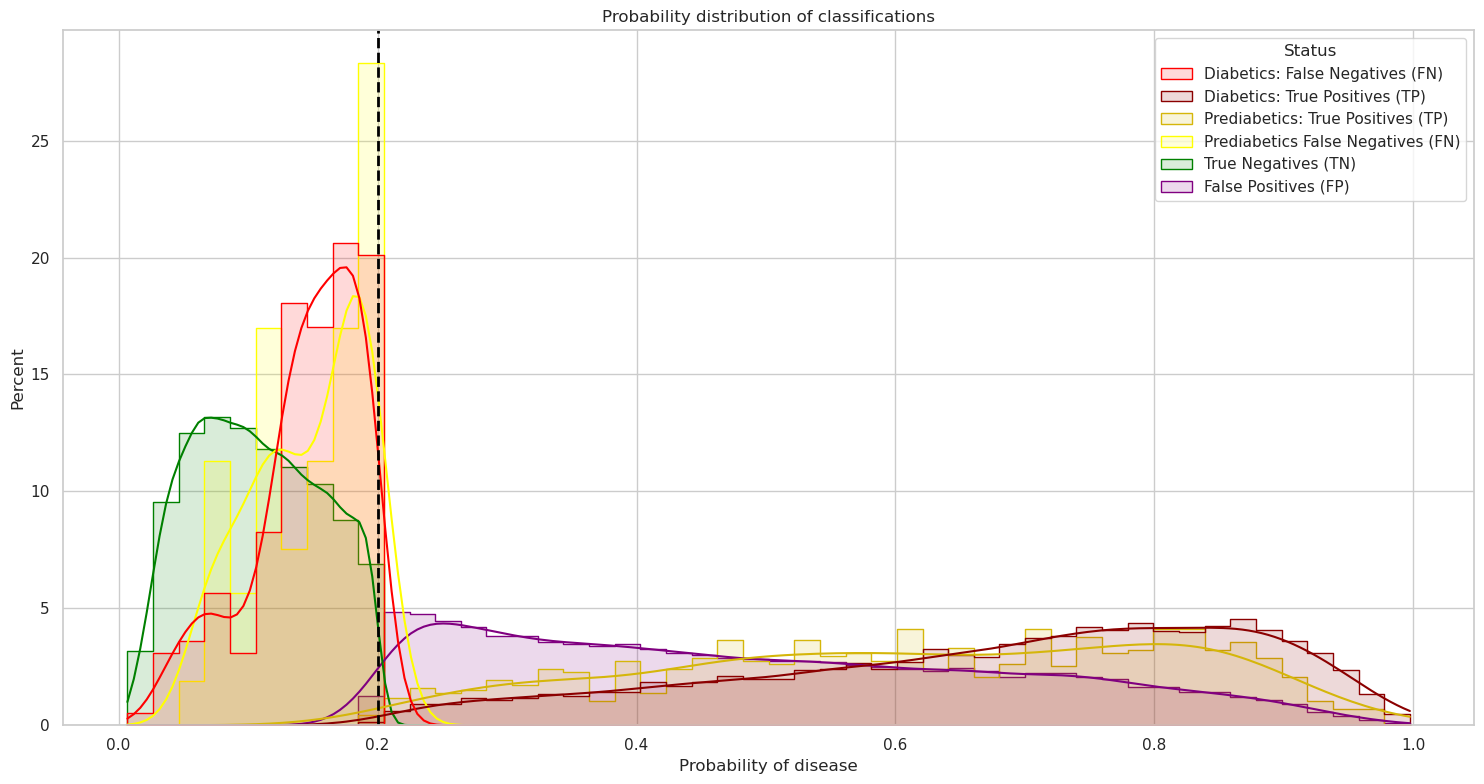

In [51]:
prob_class = logistic_reg.predict_proba(x_testing)
prob_sick = prob_class[:, 1] 

df_full = pd.DataFrame({
    'Real_Class': y_testing,       
    'Pred_Binary': y_pred,  
    'Prob_Sick': prob_sick      
})

def define_status(row):
    if row['Real_Class'] == 0:
        if row['Pred_Binary'] == 0:
            return 'True Negatives (TN)'     
        else:
            return 'False Positives (FP)'    
            
    elif row['Real_Class'] == 1:
        if row['Pred_Binary'] == 0:
            return 'Prediabetics False Negatives (FN)' 
        else:
            return 'Prediabetics: True Positives (TP)'  

    elif row['Real_Class'] == 2:
        if row['Pred_Binary'] == 0:
            return 'Diabetics: False Negatives (FN)'   
        else:
            return 'Diabetics: True Positives (TP)'    

df_full['Status'] = df_full.apply(define_status, axis=1)

my_palette = {
    'True Negatives (TN)':     'green',
    'False Positives (FP)' :    'purple',
    
    'Prediabetics False Negatives (FN)' : 'yellow', 
    'Prediabetics: True Positives (TP)' :  '#d5b60a', 
    
    'Diabetics: False Negatives (FN)':    'red',     
    'Diabetics: True Positives (TP)':     'darkred' 
}

plt.figure(figsize=(15, 8))

sns.histplot(
    data=df_full,
    x='Prob_Sick',
    hue='Status',
    kde=True,            
    stat="percent",      
    common_norm=False,    
    element="step",      
    palette=my_palette,
    alpha=0.15,
    bins=50
)




my_threshold = 0.2  
plt.axvline(x=my_threshold, color='black', linestyle='--', linewidth=2, label=f'Threshold ({my_threshold})')

plt.title('Probability distribution of classifications')
plt.xlabel('Probability of disease')
plt.tight_layout()
plt.show()

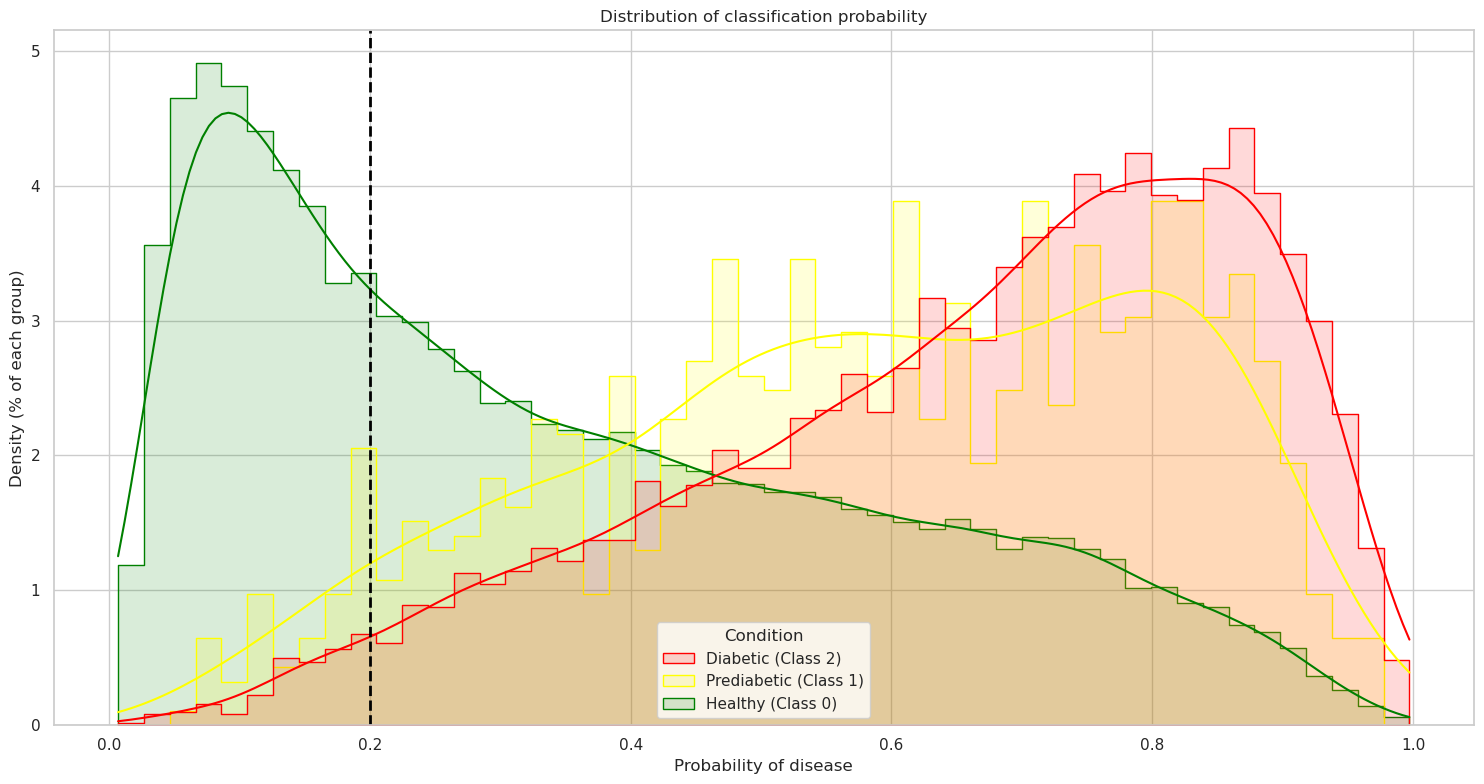

In [53]:
df_simple = pd.DataFrame({
    'Real_Class': y_testing,     
    'Prob_Sick': prob_sick       
})

class_labels = {
    0: 'Healthy (Class 0)',
    1: 'Prediabetic (Class 1)',
    2: 'Diabetic (Class 2)'
}
df_simple['Condition'] = df_simple['Real_Class'].map(class_labels)

my_palette = {
    'Healthy (Class 0)':     'green',
    'Prediabetic (Class 1)': 'yellow',
    'Diabetic (Class 2)':    'red'
}

plt.figure(figsize=(15, 8))

sns.histplot(
    data=df_simple,
    x='Prob_Sick',
    hue='Condition',
    kde=True,         
    stat="percent",
    common_norm=False,   
    element="step",     
    palette=my_palette,
    alpha=0.15,
    bins=50,
    
)


plt.axvline(x=my_threshold, color='black', linestyle='--', linewidth=2, label=f'Decision Threshold ({my_threshold})')

plt.title('Distribution of classification probability')
plt.xlabel('Probability of disease')
plt.ylabel('Density (% of each group)')

plt.tight_layout()
plt.show()

#### 3. Discussion:

Looking at the last graph, we see why we have such low specificity: there is a long tail of healthy that penetrates deep into disease territory, going all the way to the end.  
We also see that the probability distributions of diabetics and prediabetics are extremely similar, with the prediabetic probability distribution being more uniform towards lower probabilities. (it looks noisier than the other distributions, but that is because we have a lot less examples in the pre-diabetic class).  
This highlights the reason why a hierarchical classifier was unfeasable:
diabetic and prediabetic probability distribution is so similar, that you either predict every disease example as prediabetic or diabetic.  
This holds true for every other classifier that I tested as it is clear by looking at the last part of hierarchical_approach_2.ipynb script.  
The problem is strongly binary.

## False positives analysis
For a screening tool such as this model, fpr is naturally high.  
I will not focus too much of false positives

#### 1. False positives vs True positives feature distributions

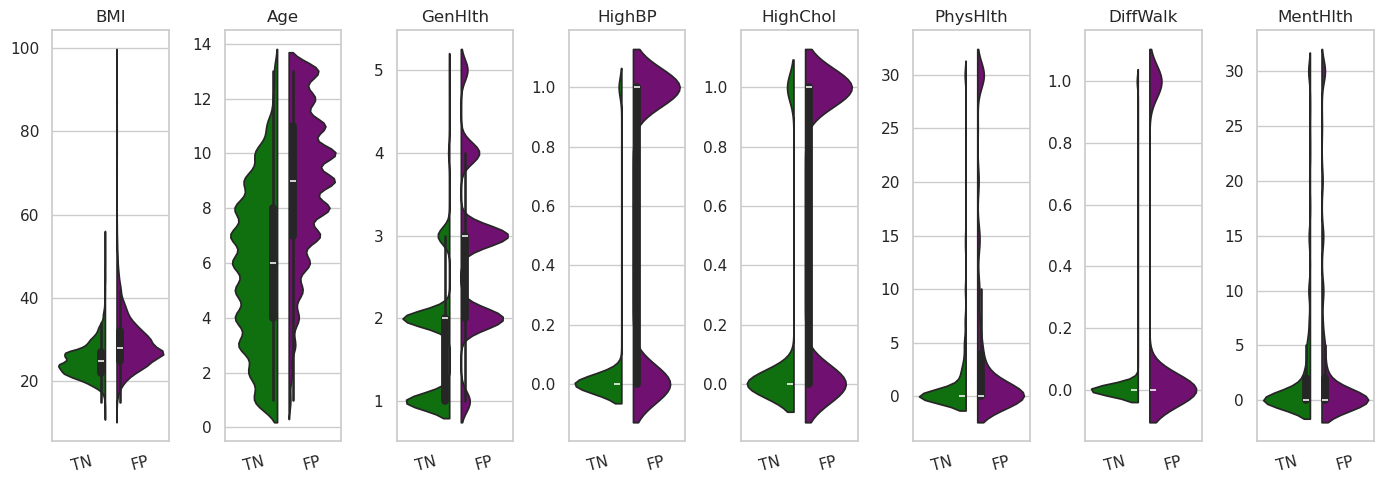

In [73]:
# create FP df
FP_df = prediction_df.query("class_ == 0 and prediction == 1").copy()
FP_df['type'] = 'FP'

# create a TN df
TN_df = prediction_df.query("class_ == 0 and prediction == 0").copy()
TN_df['type'] = 'TN'

# concatenate
TNFP_df= pd.concat([TN_df, FP_df] , axis = 0)

plt.figure(figsize=(14, 5))

for i, col in enumerate(features_to_check):
    plt.subplot(1, len(features_to_check), i+1)
    sns.violinplot(data=TNFP_df,
                x='type',
                y=col,
                palette={'FP': 'purple', 'TN': 'green'},
                split=True)
    plt.title(col)
    plt.xticks(rotation=15)
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show()

#### 1. Discussion:
False positives have much more prevalence of HighBP , HighChol, higher scores in General Health, slighly more Difficulty Walking and are in general older.  
This is a picture of a less healthy individual, and that is why the model classifies them as positives.  

### Conclusions:
This classifier can be useful as a first-line screening tool to direct people to objective tests such as blood glucose tests (which is nowadays reasonably cheap), that undoutably holds much more predictive value than a simple questionnaire.  
The advantage of this models is it's simplicity, both in terms of computation cost and architecture, making it highly interpretable and suited for large scale predictions.  
To reduce FPR, adding a question related to family history of diabetes (there may already exist a question relating to family history in the survey but in my dataset I only had a reduced number of features so I don't know) may play a crucial role.  
Training with data from other year's BRFSS may increase performance slightly.  